In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location and duration info

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-02-18_11-35-39'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp
recording_length = 10

In [6]:
ensure_dir(filename_prefix)

In [7]:
filename_prefix

PosixPath('/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-18_11-35-39')

### Get camera information

In [8]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75
Index:1	Serial:000261501812	Color:1.6.108	Depth:1.6.79


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [9]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [10]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            ###"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Testing

In [11]:
from multiprocessing import Process, Queue
from kinectacq.acquisition import capture_from_azure 

In [12]:
device_name = "master"

In [13]:
devices[device_name]["id"]

0

In [14]:
devices[device_name]["pyk4a_config"]

{'color_resolution': <ColorResolution.RES_720P: 1>,
 'depth_mode': <DepthMode.NFOV_UNBINNED: 2>}

In [15]:
k4a_obj = PyK4A(
    Config(**devices[device_name]["pyk4a_config"]),
    device_id=devices[device_name]["id"],
)

In [16]:
k4a_obj

In [17]:
k4a_obj.start()

In [82]:
capture = k4a_obj.get_capture()

In [83]:
capture.color.shape, capture.ir.shape, capture.depth.shape

((720, 1280, 4), (576, 640), (576, 640))

In [84]:
capture = k4a_obj.get_capture()
print(capture.color.shape, capture.ir.shape, capture.depth.shape)
print(capture._ir_timestamp_usec)

(720, 1280, 4) (576, 640) (576, 640)
289682755


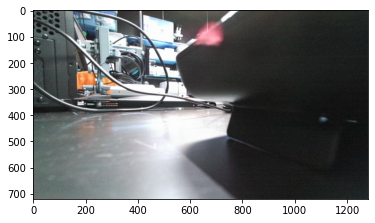

In [35]:
plt.imshow(capture.color[:,:,:3])

In [36]:
capture.color[:,:,:3].shape

(720, 1280, 3)

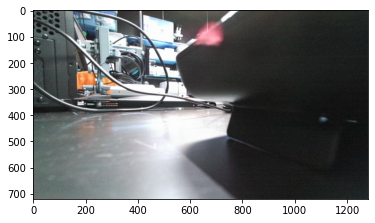

In [37]:
plt.imshow(capture.color)

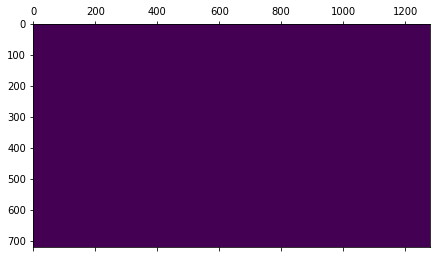

In [38]:
plt.matshow(capture.color[:,:,3])

In [39]:
capture.color.dtype

dtype('uint8')

In [40]:
capture._color_timestamp_usec

99382744

In [41]:
capture._depth_timestamp_usec

99382755

In [42]:
capture._ir_timestamp_usec

99382755

In [50]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f4ddce48940>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f4d9850a780>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': None,
 '_color_timestamp_usec': 0,
 '_color_system_timestamp_nsec': 0,
 '_color_exposure_usec': None,
 '_color_white_balance': None,
 '_depth': None,
 '_depth_timestamp_usec': 0,
 '_depth_system_timestamp_nsec': 0,
 '_ir': None,
 '_ir_timestamp_usec': 0,
 '_ir_system_timestamp_nsec': 0,
 '_depth_point_cloud': None,
 '_transformed_depth': None,
 '_transformed_depth_point_cloud': None,
 '_transformed_color': None,
 '_transformed_ir': None}

In [22]:
np.shape(capture.ir)

(576, 640)

In [23]:
capture.depth

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [24]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

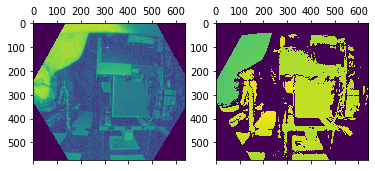

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(np.log(capture.ir+1))
ax2.matshow(np.log(capture.depth+1))

(array([2.20428e+05, 2.94360e+04, 1.00000e+00, 4.81240e+04, 5.18850e+04,
        7.24600e+03, 4.48300e+03, 5.28500e+03, 1.10000e+03, 6.52000e+02]),
 array([   0.,  593., 1186., 1779., 2372., 2965., 3558., 4151., 4744.,
        5337., 5930.]),
 <BarContainer object of 10 artists>)

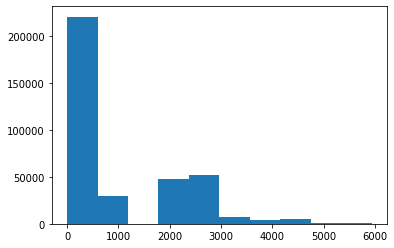

In [26]:
plt.hist(capture.depth.flatten())

In [27]:
depth = capture.depth

In [28]:
depth_pipe = None

In [29]:
from kinectacq.video_io import write_frames  

In [30]:
!ls /home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15

ls: cannot access '/home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15': No such file or directory


In [31]:
write_frames(
    filename_prefix / "test.depth.avi",
    depth.astype(np.uint8)[None, :, :],
    codec="ffv1",
    close_pipe=False,
    pipe=depth_pipe,
)

In [32]:
k4a_obj.stop()

In [90]:
import time
for i in range(10):
    capture = k4a_obj.get_capture()
    print(capture.color.shape, capture.ir.shape, capture.depth.shape)
    print(capture._ir_timestamp_usec*1e-6)
    time.sleep(1)

(720, 1280, 4) (576, 640) (576, 640)
373.182755
(720, 1280, 4) (576, 640) (576, 640)
374.182755
(720, 1280, 4) (576, 640) (576, 640)
375.182755
(720, 1280, 4) (576, 640) (576, 640)
376.182755
(720, 1280, 4) (576, 640) (576, 640)
377.182755
(720, 1280, 4) (576, 640) (576, 640)
378.182755
(720, 1280, 4) (576, 640) (576, 640)
379.182755
(720, 1280, 4) (576, 640) (576, 640)
380.182755
(720, 1280, 4) (576, 640) (576, 640)
381.182755
(720, 1280, 4) (576, 640) (576, 640)
382.182755


In [89]:
capture._ir_timestamp_usec*1e-6

311.882755

In [66]:
capture = k4a_obj.get_capture()
print(capture._ir_timestamp_usec)

0


In [105]:
capture = k4a_obj.get_capture()

In [106]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7f4ddce48940>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7f4d984e4f30>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': None,
 '_color_timestamp_usec': 0,
 '_color_system_timestamp_nsec': 0,
 '_color_exposure_usec': None,
 '_color_white_balance': None,
 '_depth': None,
 '_depth_timestamp_usec': 0,
 '_depth_system_timestamp_nsec': 0,
 '_ir': None,
 '_ir_timestamp_usec': 0,
 '_ir_system_timestamp_nsec': 0,
 '_depth_point_cloud': None,
 '_transformed_depth': None,
 '_transformed_depth_point_cloud': None,
 '_transformed_color': None,
 '_transformed_ir': None}

In [107]:
capture.color.shape#, capture.ir.shape, capture.depth.shape

(720, 1280, 4)

In [124]:
capture._color_timestamp_usec, capture._color_timestamp_usec*1e-6

(703382733, 703.3827329999999)

In [125]:
type(capture._color_timestamp_usec)

int

In [127]:
capture._color_system_timestamp_nsec

172484687609538

In [110]:
capture._color_timestamp_usec.astype('uint64')

AttributeError: 'int' object has no attribute 'astype'

In [115]:
type(time.time())

float

In [128]:
time.time_ns()

1645203935136079709

In [134]:
capture = k4a_obj.get_capture()

In [133]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [130]:
capture.ir is None

False

In [ ]:
172484687609538
1645203935136079709